In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_3:oracle.run1-oracle.run2",
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 352.4090, train_label_loss: 2.7789, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 10725.9726, train_label_loss: 2.6106, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 10751.6119, train_label_loss: 2.5721, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 11759.5771, train_label_loss: 2.3539, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 11728.3576, train_label_loss: 2.0717, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 11771.8670, train_label_loss: 1.9015, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 11740.9013, train_label_loss: 1.8099, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 11659.3171, train_label_loss: 1.7369, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 11792.8992, train_label_loss: 1.4736, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 11678.1888, train_label_loss: 1.5544, 


epoch: 1, source_val_acc_label: 0.5651, source_val_label_loss: 1.2858, target_val_acc_label: 0.4755, target_val_label_loss: 1.5276, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 12.5125, train_label_loss: 1.2539, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 10908.4563, train_label_loss: 1.0873, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 10596.4883, train_label_loss: 1.7576, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 10618.7858, train_label_loss: 1.0683, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 10564.6942, train_label_loss: 1.4845, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 10629.4952, train_label_loss: 1.1220, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 10675.8024, train_label_loss: 0.9803, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 10635.5795, train_label_loss: 0.9753, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 10512.7291, train_label_loss: 1.1498, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 10509.4156, train_label_loss: 1.1288, 


epoch: 2, source_val_acc_label: 0.7083, source_val_label_loss: 0.8618, target_val_acc_label: 0.5596, target_val_label_loss: 1.2561, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 11.7907, train_label_loss: 0.7892, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 11593.8949, train_label_loss: 1.0167, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 11626.2306, train_label_loss: 1.2899, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 11611.8758, train_label_loss: 0.8718, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 11669.1904, train_label_loss: 0.7439, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 11791.2094, train_label_loss: 0.7637, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 11618.0786, train_label_loss: 0.8691, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 11577.0890, train_label_loss: 0.9088, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 11673.8654, train_label_loss: 0.7545, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 11652.0112, train_label_loss: 0.8803, 


epoch: 3, source_val_acc_label: 0.7352, source_val_label_loss: 0.7404, target_val_acc_label: 0.5732, target_val_label_loss: 1.2796, 


New best
epoch: 4, [batch: 1 / 7000], examples_per_second: 12.3307, train_label_loss: 1.0397, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 10656.3171, train_label_loss: 0.6531, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 10633.0879, train_label_loss: 0.6619, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 10647.6286, train_label_loss: 0.6725, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 10624.5912, train_label_loss: 0.6445, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 10741.3505, train_label_loss: 0.6452, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 10594.6439, train_label_loss: 0.6794, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 10622.0509, train_label_loss: 0.9376, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 10523.8249, train_label_loss: 0.6721, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 10636.4121, train_label_loss: 0.6971, 


epoch: 4, source_val_acc_label: 0.7582, source_val_label_loss: 0.6758, target_val_acc_label: 0.5910, target_val_label_loss: 1.2332, 


New best
epoch: 5, [batch: 1 / 7000], examples_per_second: 11.5751, train_label_loss: 0.5818, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 10648.0145, train_label_loss: 0.6921, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 11708.4090, train_label_loss: 0.5370, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 11708.7077, train_label_loss: 1.0468, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 11753.0768, train_label_loss: 0.7125, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 11657.0036, train_label_loss: 0.9014, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 11719.0895, train_label_loss: 0.5058, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 11882.9923, train_label_loss: 0.4523, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 11739.5700, train_label_loss: 0.7408, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 11774.6705, train_label_loss: 0.5615, 


epoch: 5, source_val_acc_label: 0.7662, source_val_label_loss: 0.6361, target_val_acc_label: 0.5992, target_val_label_loss: 1.2603, 


New best
epoch: 6, [batch: 1 / 7000], examples_per_second: 13.5616, train_label_loss: 0.5154, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 10759.1261, train_label_loss: 0.6059, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 10696.4551, train_label_loss: 0.4442, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 10669.6559, train_label_loss: 0.3592, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 10676.6140, train_label_loss: 0.6854, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 10689.8822, train_label_loss: 0.6307, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 10689.4933, train_label_loss: 0.5272, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 10738.1006, train_label_loss: 0.4747, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 10664.0487, train_label_loss: 0.7211, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 10652.1463, train_label_loss: 0.7777, 


epoch: 6, source_val_acc_label: 0.7644, source_val_label_loss: 0.6355, target_val_acc_label: 0.5942, target_val_label_loss: 1.2976, 


epoch: 7, [batch: 1 / 7000], examples_per_second: 13.0890, train_label_loss: 0.7165, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 11750.3848, train_label_loss: 0.2887, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 11846.6558, train_label_loss: 0.3342, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 11766.6233, train_label_loss: 0.5584, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 11761.3153, train_label_loss: 0.3785, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 11747.8208, train_label_loss: 0.4401, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 11706.2167, train_label_loss: 0.5501, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 11915.1902, train_label_loss: 0.4367, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 11637.3494, train_label_loss: 0.4294, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 10757.8015, train_label_loss: 0.4068, 


epoch: 7, source_val_acc_label: 0.7539, source_val_label_loss: 0.6886, target_val_acc_label: 0.5935, target_val_label_loss: 1.3793, 


epoch: 8, [batch: 1 / 7000], examples_per_second: 11.6517, train_label_loss: 0.3555, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 10667.3728, train_label_loss: 0.3336, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 10684.8038, train_label_loss: 0.4119, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 10761.8732, train_label_loss: 0.4058, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 10691.9396, train_label_loss: 0.5978, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 10733.8261, train_label_loss: 0.4204, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 10762.8176, train_label_loss: 0.4422, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 10722.3307, train_label_loss: 0.3581, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 10712.5901, train_label_loss: 0.3775, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 10683.8913, train_label_loss: 0.3434, 


epoch: 8, source_val_acc_label: 0.7615, source_val_label_loss: 0.6604, target_val_acc_label: 0.5941, target_val_label_loss: 1.4190, 


epoch: 9, [batch: 1 / 7000], examples_per_second: 11.4983, train_label_loss: 0.2845, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 10740.5390, train_label_loss: 0.2920, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 11286.4763, train_label_loss: 0.5067, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 11811.2183, train_label_loss: 0.5603, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 11782.8340, train_label_loss: 0.4612, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 11688.9288, train_label_loss: 0.3915, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 11744.7860, train_label_loss: 0.3668, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 11837.9961, train_label_loss: 0.3225, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 11793.7775, train_label_loss: 0.3820, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 11803.2078, train_label_loss: 0.3204, 


epoch: 9, source_val_acc_label: 0.7785, source_val_label_loss: 0.6064, target_val_acc_label: 0.6046, target_val_label_loss: 1.4107, 


New best
epoch: 10, [batch: 1 / 7000], examples_per_second: 13.3664, train_label_loss: 0.2956, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 10975.9407, train_label_loss: 0.2173, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 10710.0370, train_label_loss: 0.2900, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 10722.7263, train_label_loss: 0.2730, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 10720.4043, train_label_loss: 0.3290, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 10738.3555, train_label_loss: 0.3677, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 10673.5586, train_label_loss: 0.4394, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 10944.7582, train_label_loss: 0.3623, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 11741.9897, train_label_loss: 0.2555, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 11707.8356, train_label_loss: 0.3583, 


epoch: 10, source_val_acc_label: 0.7803, source_val_label_loss: 0.6117, target_val_acc_label: 0.6014, target_val_label_loss: 1.4668, 


epoch: 11, [batch: 1 / 7000], examples_per_second: 13.2488, train_label_loss: 0.2519, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 11772.2532, train_label_loss: 0.3148, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 11784.2887, train_label_loss: 0.2321, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 11771.0400, train_label_loss: 0.2623, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 11690.2999, train_label_loss: 0.3648, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 12108.3284, train_label_loss: 0.3953, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 11320.9229, train_label_loss: 0.2821, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 10737.1744, train_label_loss: 0.2713, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 10750.9555, train_label_loss: 0.3867, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 10734.8903, train_label_loss: 0.4509, 


epoch: 11, source_val_acc_label: 0.7687, source_val_label_loss: 0.6636, target_val_acc_label: 0.5931, target_val_label_loss: 1.5956, 


epoch: 12, [batch: 1 / 7000], examples_per_second: 11.5423, train_label_loss: 0.1499, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 10725.2807, train_label_loss: 0.2530, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 10682.4418, train_label_loss: 0.3793, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 10727.9488, train_label_loss: 0.3853, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 10758.9226, train_label_loss: 0.2438, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 10790.0394, train_label_loss: 0.3747, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 10718.7914, train_label_loss: 0.2530, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 10664.0895, train_label_loss: 0.2982, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 10719.8946, train_label_loss: 0.2972, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 10746.1300, train_label_loss: 0.3887, 


epoch: 12, source_val_acc_label: 0.7580, source_val_label_loss: 0.7068, target_val_acc_label: 0.5915, target_val_label_loss: 1.6573, 


epoch: 13, [batch: 1 / 7000], examples_per_second: 11.6154, train_label_loss: 0.2653, 


epoch: 13, [batch: 700 / 7000], examples_per_second: 10741.5704, train_label_loss: 0.1598, 


epoch: 13, [batch: 1400 / 7000], examples_per_second: 10902.6672, train_label_loss: 0.2514, 


epoch: 13, [batch: 2100 / 7000], examples_per_second: 11773.6111, train_label_loss: 0.2504, 


epoch: 13, [batch: 2800 / 7000], examples_per_second: 11796.7099, train_label_loss: 0.5171, 


epoch: 13, [batch: 3500 / 7000], examples_per_second: 11764.6478, train_label_loss: 0.2714, 


epoch: 13, [batch: 4200 / 7000], examples_per_second: 11783.4425, train_label_loss: 0.3193, 


epoch: 13, [batch: 4900 / 7000], examples_per_second: 11791.0433, train_label_loss: 0.1903, 


epoch: 13, [batch: 5600 / 7000], examples_per_second: 11926.2538, train_label_loss: 0.1976, 


epoch: 13, [batch: 6300 / 7000], examples_per_second: 11778.4926, train_label_loss: 0.2696, 


epoch: 13, source_val_acc_label: 0.7759, source_val_label_loss: 0.6587, target_val_acc_label: 0.6097, target_val_label_loss: 1.6151, 


New best
epoch: 14, [batch: 1 / 7000], examples_per_second: 13.2270, train_label_loss: 0.1527, 


epoch: 14, [batch: 700 / 7000], examples_per_second: 11709.2034, train_label_loss: 0.3222, 


epoch: 14, [batch: 1400 / 7000], examples_per_second: 10763.6499, train_label_loss: 0.3819, 


epoch: 14, [batch: 2100 / 7000], examples_per_second: 10579.3250, train_label_loss: 0.3091, 


epoch: 14, [batch: 2800 / 7000], examples_per_second: 10694.0958, train_label_loss: 0.3367, 


epoch: 14, [batch: 3500 / 7000], examples_per_second: 11113.4721, train_label_loss: 0.2686, 


epoch: 14, [batch: 4200 / 7000], examples_per_second: 11746.2947, train_label_loss: 0.2946, 


epoch: 14, [batch: 4900 / 7000], examples_per_second: 11724.8836, train_label_loss: 0.4358, 


epoch: 14, [batch: 5600 / 7000], examples_per_second: 11653.4619, train_label_loss: 0.3988, 


epoch: 14, [batch: 6300 / 7000], examples_per_second: 11751.4700, train_label_loss: 0.2463, 


epoch: 14, source_val_acc_label: 0.7678, source_val_label_loss: 0.7003, target_val_acc_label: 0.6096, target_val_label_loss: 1.6113, 


epoch: 15, [batch: 1 / 7000], examples_per_second: 13.2433, train_label_loss: 0.1638, 


epoch: 15, [batch: 700 / 7000], examples_per_second: 11763.2264, train_label_loss: 0.2350, 


epoch: 15, [batch: 1400 / 7000], examples_per_second: 11769.3800, train_label_loss: 0.3514, 


epoch: 15, [batch: 2100 / 7000], examples_per_second: 12273.3690, train_label_loss: 0.1437, 


epoch: 15, [batch: 2800 / 7000], examples_per_second: 11026.6013, train_label_loss: 0.2306, 


epoch: 15, [batch: 3500 / 7000], examples_per_second: 10734.5693, train_label_loss: 0.3686, 


epoch: 15, [batch: 4200 / 7000], examples_per_second: 10738.0825, train_label_loss: 0.2157, 


epoch: 15, [batch: 4900 / 7000], examples_per_second: 10721.4500, train_label_loss: 0.2265, 


epoch: 15, [batch: 5600 / 7000], examples_per_second: 10696.3641, train_label_loss: 0.2552, 


epoch: 15, [batch: 6300 / 7000], examples_per_second: 10718.1161, train_label_loss: 0.2979, 


epoch: 15, source_val_acc_label: 0.7686, source_val_label_loss: 0.7009, target_val_acc_label: 0.6040, target_val_label_loss: 1.6803, 


epoch: 16, [batch: 1 / 7000], examples_per_second: 11.7048, train_label_loss: 0.3488, 


epoch: 16, [batch: 700 / 7000], examples_per_second: 10713.1214, train_label_loss: 0.1752, 


epoch: 16, [batch: 1400 / 7000], examples_per_second: 10733.2933, train_label_loss: 0.1891, 


epoch: 16, [batch: 2100 / 7000], examples_per_second: 10757.7630, train_label_loss: 0.1933, 


epoch: 16, [batch: 2800 / 7000], examples_per_second: 10752.8843, train_label_loss: 0.2438, 


epoch: 16, [batch: 3500 / 7000], examples_per_second: 10595.5239, train_label_loss: 0.1463, 


epoch: 16, [batch: 4200 / 7000], examples_per_second: 10738.7904, train_label_loss: 0.1288, 


epoch: 16, [batch: 4900 / 7000], examples_per_second: 10710.1407, train_label_loss: 0.1743, 


epoch: 16, [batch: 5600 / 7000], examples_per_second: 10732.1714, train_label_loss: 0.3658, 


epoch: 16, [batch: 6300 / 7000], examples_per_second: 10709.0014, train_label_loss: 0.1945, 


epoch: 16, source_val_acc_label: 0.7692, source_val_label_loss: 0.7274, target_val_acc_label: 0.5935, target_val_label_loss: 1.7808, 


epoch: 17, [batch: 1 / 7000], examples_per_second: 11.5847, train_label_loss: 0.2035, 


epoch: 17, [batch: 700 / 7000], examples_per_second: 10618.6726, train_label_loss: 0.1749, 


epoch: 17, [batch: 1400 / 7000], examples_per_second: 10727.8349, train_label_loss: 0.2002, 


epoch: 17, [batch: 2100 / 7000], examples_per_second: 11451.7660, train_label_loss: 0.1934, 


epoch: 17, [batch: 2800 / 7000], examples_per_second: 11744.8766, train_label_loss: 0.1316, 


epoch: 17, [batch: 3500 / 7000], examples_per_second: 11787.2500, train_label_loss: 0.2208, 


epoch: 17, [batch: 4200 / 7000], examples_per_second: 11771.6804, train_label_loss: 0.1201, 


epoch: 17, [batch: 4900 / 7000], examples_per_second: 11759.5683, train_label_loss: 0.2574, 


epoch: 17, [batch: 5600 / 7000], examples_per_second: 11881.2176, train_label_loss: 0.2283, 


epoch: 17, [batch: 6300 / 7000], examples_per_second: 11804.9889, train_label_loss: 0.2656, 


epoch: 17, source_val_acc_label: 0.7663, source_val_label_loss: 0.7341, target_val_acc_label: 0.5875, target_val_label_loss: 1.8443, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

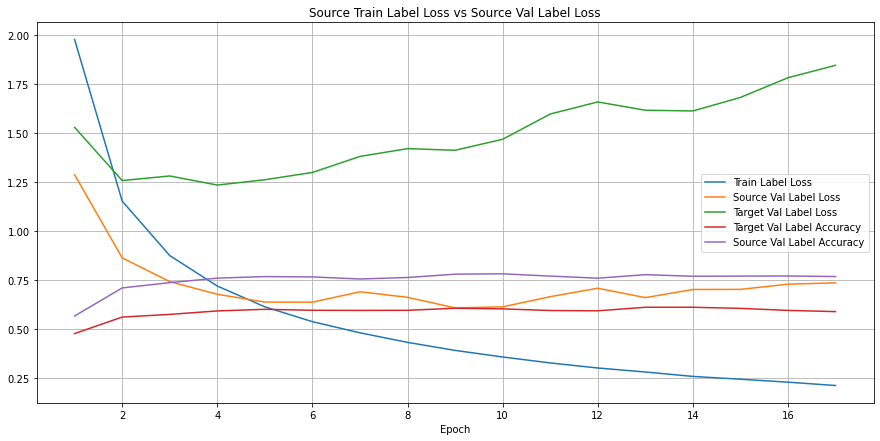

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

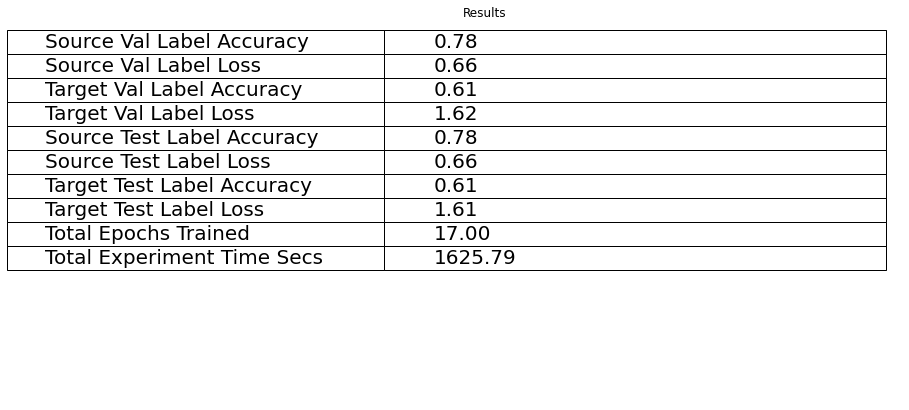

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

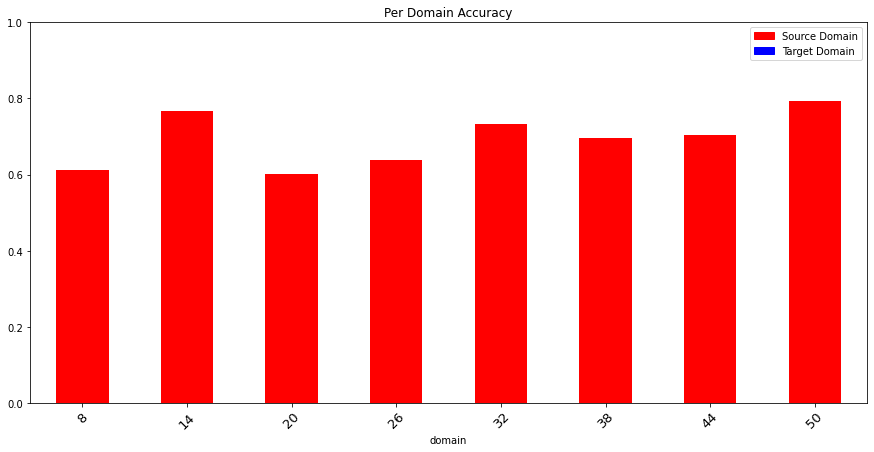

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.77515625 Target Test Label Accuracy: 0.611140625
Source Val Label Accuracy: 0.7759375 Target Val Label Accuracy: 0.60965625


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_3:oracle.run1-oracle.run2", "parameters": {"experiment_name": "cnn_3:oracle.run1-oracle.run2", "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels